- https://www.dmi.dk/data/
- https://confluence.govcloud.dk/display/FDAPI/DMI+Data+API

API key: c0616eb5-0571-4bc8-a3fa-9b8d0ae0d82c

PREVIOUS NOTES: 
NOTE: extarcted some data from DMI , so far got the API for climate data (documentation: https://opendatadocs.dmi.govcloud.dk/Data/Climate_Data)to extract features i need to change station everytime and check what this station calculates. i can aggregate more station in cph and get the different paramenters all together becuase i cant find one station that has it all. 

need to check more about the api for meteorogical obs data (documentation: https://opendatadocs.dmi.govcloud.dk/en/Data/Meteorological_Observation_Data) becuase the api doesent work here and dont know how to solve it. 

In [1]:
import requests
import json
import os 
import calendar
import geopandas as gpd
from shapely.geometry import Point, shape
import pandas as pd

this are the variables i should extract from the stations in my considered area. 

| **Category**                                         | **Variable name (in DMI API)**     | **Unit**                          | **Meaning / Why it’s useful**                                             |
| ---------------------------------------------------- | ---------------------------------- | --------------------------------- | ------------------------------------------------------------------------- |
| 🌡️ **Temperature**                                  | `mean_temp`                        | °C                                | Average air temperature during the period                                 |
|                                                      | `mean_daily_max_temp`              | °C                                | Captures warmest moments (comfort/discomfort)                             |
|                                                      | `mean_daily_min_temp`              | °C                                | Night cooling / daily variation                                           |
| ☀️ **Sunlight / Radiation**                          | `bright_sunshine`                  | hours (daily) or minutes (hourly) | Total duration of sunshine — key for mood, exposure, and outdoor activity |
|                                                      | `mean_radiation`                   | MJ/m² (daily) or W/m² (hourly)    | Total incoming solar energy                                               |
| 🌧️ **Precipitation**                                | `acc_precip`                       | mm                                | Total rainfall in the period                                              |
|                                                      | `max_precip_24h`                   | mm                                | Max daily rain intensity (helps detect extreme days)                      |
| 💨 **Wind**                                          | `mean_wind_speed`                  | m/s                               | Comfort, exposure, air movement                                           |
|                                                      | `mean_wind_dir`                    | degrees                           | Direction of dominant wind (optional, for exposure mapping)               |
| 💧 **Humidity / Pressure**                           | `mean_relative_hum`                | %                                 | Affects comfort and perception                                            |
|                                                      | `mean_pressure`                    | hPa                               | Atmospheric context, useful in weather-type clustering                    |
| ☁️ **Clouds / Visibility**                           | `mean_cloud_cover`                 | %                                 | How cloudy the sky is — inversely related to sunshine                     |
| ❄️ **Snow** | `snow_depth`, `no_days_snow_cover` | cm / count                        | For seasonal modeling or winter comparisons                               |

good pipeline would be: 
- extract the station in my bounded area
- see which station claculates what and create a sort of a table to sumarize which variables are claculated in the stations
- check if the thing is cool and instead it could be useful to use the already made aggreagation '10kmGridValue' made by them in order to have it easier for the grid cell later??


In [2]:
# saving the weather stations of denamrk with API 
data_path = '/home/s232713/data/'

# Your DMI API key
API_KEY = "ef71297e-dc27-4f7b-b5e4-53baeacf8d05"

# Base URL for metObsAPI
BASE_URL = "https://dmigw.govcloud.dk/v2/climateData"

# Endpoint for station metadata
url = f"{BASE_URL}/collections/station/items?limit=1000"  # limit high enough to get all stations

headers = {"X-Gravitee-Api-Key": API_KEY}
response = requests.get(url, headers=headers)

if response.status_code == 200:
    stations = response.json()

    # Save full list to a JSON for inspection
    with open(data_path + "DMI/stations_metadata.json", "w", encoding="utf-8") as f:
        json.dump(stations, f, ensure_ascii=False, indent=4)

    print("Stations metadata saved to DMI/stations_metadata.json")

else:
    print(f"Error fetching stations: {response.status_code}")


Stations metadata saved to DMI/stations_metadata.json


In [3]:
# stations
data_path = '/home/s232713/data/'
with open(data_path + "DMI/stations_metadata.json", "r", encoding="utf-8") as f:
    stations_data = json.load(f)

stations_gdf = gpd.GeoDataFrame(
    [
        {
            "stationId": feat["properties"]["stationId"],
            "name": feat["properties"]["name"],
            "type": feat["properties"]["type"],
            "variables": feat["properties"]["parameterId"],
            "geometry": Point(feat["geometry"]["coordinates"]),
        }
        for feat in stations_data["features"]
    ],
    crs="EPSG:4326"
)

# boundaries
boundary_gdf = gpd.read_file(data_path + "grid_data/copenhagen_union_boundary.geojson")

# Ensure same CRS
if boundary_gdf.crs != "EPSG:4326":
    boundary_gdf = boundary_gdf.to_crs("EPSG:4326")

# spatial filter
stations_in_boundary = stations_gdf[stations_gdf.within(boundary_gdf.unary_union)]

# results
print(f"Stations inside boundary: {len(stations_in_boundary)}\n")
print(stations_in_boundary[["stationId", "name", "type"]])

# Optional: preview the variable coverage per station
for _, row in stations_in_boundary.iterrows():
    print(f"\n{row['name']} ({row['stationId']}) → measures:")
    print(", ".join(row["variables"]))


Stations inside boundary: 29

    stationId                    name         type
106     05575                 Græsted       Pluvio
107     05575                 Græsted       Pluvio
108     05735           Botanisk Have       Pluvio
109     05735           Botanisk Have       Pluvio
110     05735           Botanisk Have       Pluvio
111     05735      Livgardens Kaserne       Pluvio
385     06168          Nakkehoved Fyr        Synop
386     06168          Nakkehoved Fyr        Synop
387     06168          Nakkehoved Fyr        Synop
388     06168          Nakkehoved Fyr        Synop
407     06180     Københavns Lufthavn        Synop
408     06180     Københavns Lufthavn        Synop
409     06180     Københavns Lufthavn        Synop
410     06180     Københavns Lufthavn        Synop
411     06181              Jægersborg        Synop
412     06181              Jægersborg        Synop
413     06181              Jægersborg        Synop
414     06186         Landbohøjskolen        Synop
4

/tmp/ipykernel_909059/3549188178.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_boundary = stations_gdf[stations_gdf.within(boundary_gdf.unary_union)]


the ClimateData API support the extraction of their aggregation 10km grid. this is gonna be extracted and then filtered with the boundaries i have and then saved as a json file. 

the 10x10 grid was downloaded from the DMI's github repository: https://github.com/dmidk/Climate-Data-Grid-Map/tree/main

In [4]:
# Load both layers
grid_gdf = gpd.read_file(data_path + 'DMI/10x10.geojson')
# boundary_gdf = gpd.read_file(boundary_path)

# --- Check and align coordinate systems ---
if boundary_gdf.crs != grid_gdf.crs:
    boundary_gdf = boundary_gdf.to_crs(grid_gdf.crs)

# --- Filter grid cells that intersect your boundary ---
boundary_union = boundary_gdf.unary_union
grid_in_boundary = grid_gdf[grid_gdf.intersects(boundary_union)]

print(f"10×10 km grid cells inside boundary: {len(grid_in_boundary)}")
print(grid_in_boundary[['cellId']].head())

# - `grid_in_boundary` is a GeoDataFrame with the clipped grid cells
# - `subset_obj` is a JSON/dict version for later use


10×10 km grid cells inside boundary: 36
          cellId
260  10km_616_69
261  10km_616_70
262  10km_616_71
263  10km_616_72
264  10km_616_73


/tmp/ipykernel_909059/1522213616.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  boundary_union = boundary_gdf.unary_union


having the grid cell necessary now i can call tyhe API and extract the features in the cells i need

these are the parameters extracted: 
| Parameter ID        | Unit  | Meaning                    | Relevance                     |
| ------------------- | ----- | -------------------------- | ----------------------------- |
| `mean_temp`         | °C    | Daily mean air temperature | General comfort / heat stress |
| `acc_precip`        | mm    | Total precipitation accumulated        | Rain exposure / wetness       |
| `bright_sunshine`   | hours | Duration of sunshine       | Light exposure / mood         |
| `mean_wind_speed`   | m/s   | Average wind speed         | Wind-chill, comfort           |
| `mean_relative_hum` | %     | Average relative humidity  | Humidity stress               |
| `mean_pressure`     | hPa   | Mean sea-level pressure    | Weather system indicator      |
| `mean_cloud_cover`  | %     | Average cloud fraction     | Sky condition / light         |


In [5]:
url = "https://dmigw.govcloud.dk/v2/climateData/collections/10kmGridValue/items"

parameters = [
    "mean_temp",
    "acc_precip",
    "bright_sunshine",
    "mean_wind_speed",
    "mean_relative_hum",
    "mean_pressure",
    "mean_cloud_cover"
]

# range of the FINAL_foot data
date_from = "2023-11-07T00:00:00Z"
date_to   = "2024-07-21T23:59:59Z"
datetime_str = f"{date_from}/{date_to}"

# boundary bbox (lon/lat order). Tell API the CRS to avoid axis ambiguity.
minx, miny, maxx, maxy = boundary_union.bounds
bbox_str = f"{minx},{miny},{maxx},{maxy}"


grid_ids = grid_in_boundary['cellId'].tolist()

def fetch_param_cellids(parameter_id, cell_ids):
    frames = []
    for cid in cell_ids:
        params = {
            "api-key": API_KEY,
            "parameterId": parameter_id,
            "timeResolution": "day",
            "datetime": datetime_str, 
            "cellId": cid,
            "limit": 10000
        }
        r = requests.get(url, params=params, timeout=60)
        r.raise_for_status()
        rows = []
        for f in r.json().get("features", []):
            p = f["properties"]
            rows.append({"grid_id": p.get("cellId", cid),
                         "date": p["from"][:10], parameter_id: p["value"]})
        if rows:
            frames.append(pd.DataFrame(rows))
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

frames = []
for param in parameters:
    frames.append(fetch_param_cellids(param, grid_ids))

df = frames[0]
for nxt in frames[1:]:
    df = df.merge(nxt, on=["grid_id","date"], how="outer")

print(df.head())


       grid_id        date  mean_temp  acc_precip  bright_sunshine  \
0  10km_616_69  2023-11-08        8.6         0.8              2.3   
1  10km_616_69  2023-11-09        8.2         2.2              0.0   
2  10km_616_69  2023-11-10        6.7         4.8              0.9   
3  10km_616_69  2023-11-11        6.9         0.4              1.2   
4  10km_616_69  2023-11-12        5.9         1.4              0.2   

   mean_wind_speed  mean_relative_hum  mean_pressure  mean_cloud_cover  
0              4.6               88.0         1004.6              83.0  
1              4.4               94.5          999.0              90.0  
2              3.9               91.4          995.9              87.0  
3              1.9               92.2         1000.6              88.0  
4              1.6               92.4         1005.3              97.0  


daily climates values in parametes has been extarcted for the 10x10 grid 

In [6]:
print(len(df['grid_id'].unique()))

36


I have a csv where I saved the active hexagons (the ones touched by a path) (in the cvs I have 2 column GRID_ID and TRIP_ID). I want for now to extract the weather data just for the active grid. in my head the process is like overlapping the 10x10km dmi grid with my active grid and if an active hexagon is in a 10x10km square of the dmi grid it takes those weather variable with every date

In [7]:
active_hex = pd.read_csv(data_path + 'grid_data/grid_to_trip.csv')
hex_grid = gpd.read_file(data_path + 'grid_data/cph_hexgrid.geojson')
dmi_grid = gpd.read_file(data_path + 'DMI/10x10.geojson')
weather_df = df


In [14]:
print(dmi_grid.columns)
print(hex_grid.columns)

Index(['cellId', 'geometry'], dtype='object')
Index(['GRID_ID', 'geometry'], dtype='object')


In [8]:
# only active hexagons
active_hex_ids = active_hex['GRID_ID'].unique()
active_hex_gdf = hex_grid[hex_grid['GRID_ID'].isin(active_hex_ids)]

# align coordinate system
active_hex_gdf = active_hex_gdf.to_crs(dmi_grid.crs)

In [16]:
# 1. Intersezione in CRS metrico
dmi_grid_m = dmi_grid.to_crs(3857)
active_hex_gdf_m = active_hex_gdf.to_crs(3857)
tmp = gpd.overlay(dmi_grid_m, active_hex_gdf_m, how="intersection")

# 2. Area dell'intersezione
tmp["area_inter"] = tmp.geometry.area

# 3. Ordina per area crescente
tmp = tmp.sort_values("area_inter")

# 4. Una riga per ogni esagono (GRID_ID), prendo quella con area maggiore
tmp_unique = tmp.drop_duplicates(subset="GRID_ID", keep="last")

# 5. Tengo tutte le colonne DMI + GRID_ID, senza geometry
cols_to_keep = ["GRID_ID"] + [c for c in dmi_grid.columns if c != "geometry"]
intersected = tmp_unique[cols_to_keep].copy()





In [ ]:
# --- Spatial join: which DMI 10×10 cells intersect active hexes ---
# intersected = gpd.sjoin(dmi_grid, active_hex_gdf, how="inner", predicate="intersects")
#print(intersected.head())


In [17]:
# --- Get the relevant DMI cell IDs ---
active_dmi_ids = intersected["cellId"].unique().tolist()
print(f"Active DMI grid cells overlapping hexes: {len(active_dmi_ids)}")


Active DMI grid cells overlapping hexes: 21


In [18]:
# --- Filter the saved weather data ---
weather_active = weather_df[weather_df["grid_id"].isin(active_dmi_ids)].copy()

print(weather_active.head())
print(weather_active["grid_id"].nunique(), "unique DMI cells kept")

         grid_id        date  mean_temp  acc_precip  bright_sunshine  \
258  10km_616_70  2023-11-08        8.8         1.2              2.2   
259  10km_616_70  2023-11-09        8.4         2.0              0.0   
260  10km_616_70  2023-11-10        7.1         3.9              1.0   
261  10km_616_70  2023-11-11        7.2         0.5              1.3   
262  10km_616_70  2023-11-12        6.0         1.0              0.3   

     mean_wind_speed  mean_relative_hum  mean_pressure  mean_cloud_cover  
258              4.6               88.0         1004.7              82.0  
259              4.5               94.4          999.1              90.0  
260              3.8               90.8          996.0              85.0  
261              1.9               91.8         1000.7              88.0  
262              1.5               92.6         1005.4              95.0  
21 unique DMI cells kept


In [19]:
print(weather_active['date'].min(), ' to ', weather_active['date'].max())

2023-11-08  to  2024-07-22


In [20]:
# spatial join
hex_to_dmi = gpd.sjoin(active_hex_gdf, dmi_grid, how="left", predicate="intersects")

hex_to_dmi = hex_to_dmi[["GRID_ID", "cellId"]].drop_duplicates()
print(f"{len(hex_to_dmi)} hex–DMI links created")

# merge with weather data
weather_active = weather_active.rename(columns={"grid_id": "cellId"})

# combine weather with hex–DMI mapping
hex_weather = hex_to_dmi.merge(weather_active, on="cellId", how="left")

print(hex_weather.head())

# cellId is the DMI 10x10 cell ID
# GRID_ID is the hexagon ID

13149 hex–DMI links created
   GRID_ID       cellId        date  mean_temp  acc_precip  bright_sunshine  \
0     8989  10km_620_68  2023-11-08        8.8         0.8              2.1   
1     8989  10km_620_68  2023-11-09        8.5         4.8              0.0   
2     8989  10km_620_68  2023-11-10        7.0         4.4              0.6   
3     8989  10km_620_68  2023-11-11        7.0         1.2              1.5   
4     8989  10km_620_68  2023-11-12        6.1         0.7              0.1   

   mean_wind_speed  mean_relative_hum  mean_pressure  mean_cloud_cover  
0              5.7               89.8         1003.8              74.0  
1              4.8               96.1          998.3              84.0  
2              4.7               93.9          995.4              78.0  
3              1.7               93.4         1000.6              86.0  
4              1.5               95.2         1005.4              75.0  


In [24]:
# save file 
hex_weather.to_csv(data_path + "DMI/grid_weather.csv", index=False)
print(f"Hex-weather data saved to: {data_path + 'DMI/grid_weather.csv'}")

Hex-weather data saved to: /home/s232713/data/DMI/grid_weather.csv


In [21]:
print(len(weather_active['date'].unique()))
print(len(hex_weather['date'].unique()))

258
258


In [22]:
print(hex_weather['GRID_ID'].nunique())
print(active_hex['GRID_ID'].nunique())

12920
12920


In [25]:
data_path = '/home/s232713/data/'
hex_weather = pd.read_csv(data_path + "DMI/grid_weather.csv")
print(hex_weather.shape)

(3392442, 10)


# Visualizations

In [2]:
import pandas as pd

data_path = '/home/s232713/data/'
df_weather = pd.read_csv(data_path + "DMI/grid_weather.csv")

df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather["date"].head()
df_weather["date"].dtype
df_weather["date"].min(), df_weather["date"].max()


(Timestamp('2023-11-08 00:00:00'), Timestamp('2024-07-22 00:00:00'))

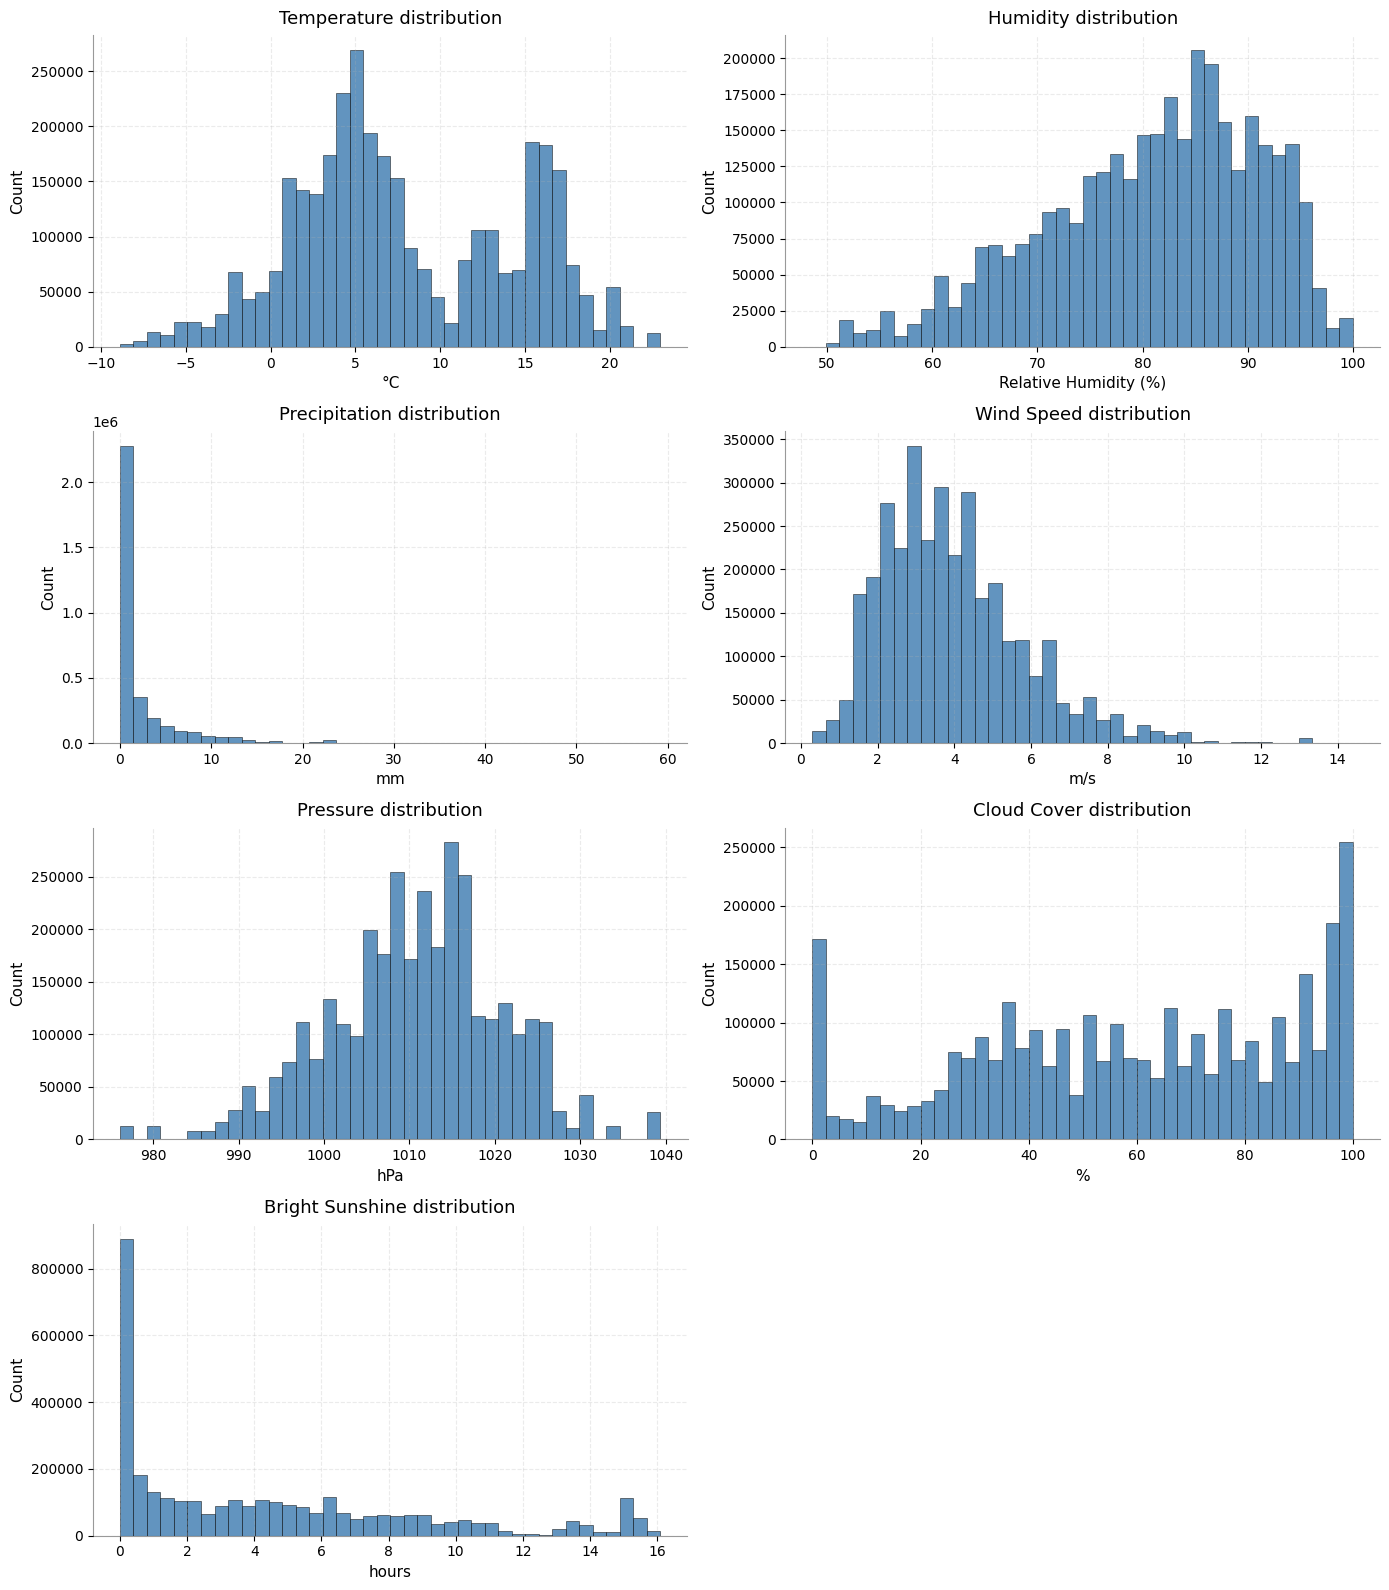

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

plots = [
    ("mean_temp", "Temperature distribution", "°C"),
    ("mean_relative_hum", "Humidity distribution", "Relative Humidity (%)"),
    ("acc_precip", "Precipitation distribution", "mm"),
    ("mean_wind_speed", "Wind Speed distribution", "m/s"),
    ("mean_pressure", "Pressure distribution", "hPa"),
    ("mean_cloud_cover", "Cloud Cover distribution", "%"),
    ("bright_sunshine", "Bright Sunshine distribution", "hours"),
]

for ax, (col, title, xlabel) in zip(axes, plots):
    
    # histogram
    ax.hist(
        df_weather[col].dropna(),
        bins=40,
        color="steelblue",
        edgecolor="black",
        linewidth=0.4,
        alpha=0.85
    )
    
    # titles and labels
    ax.set_title(title, fontsize=13, pad=8)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    
    # grid
    ax.grid(True, linestyle="--", alpha=0.25)
    
    # remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # soften left and bottom spines
    ax.spines["left"].set_alpha(0.4)
    ax.spines["bottom"].set_alpha(0.4)

# remove extra empty axis
for j in range(len(plots), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


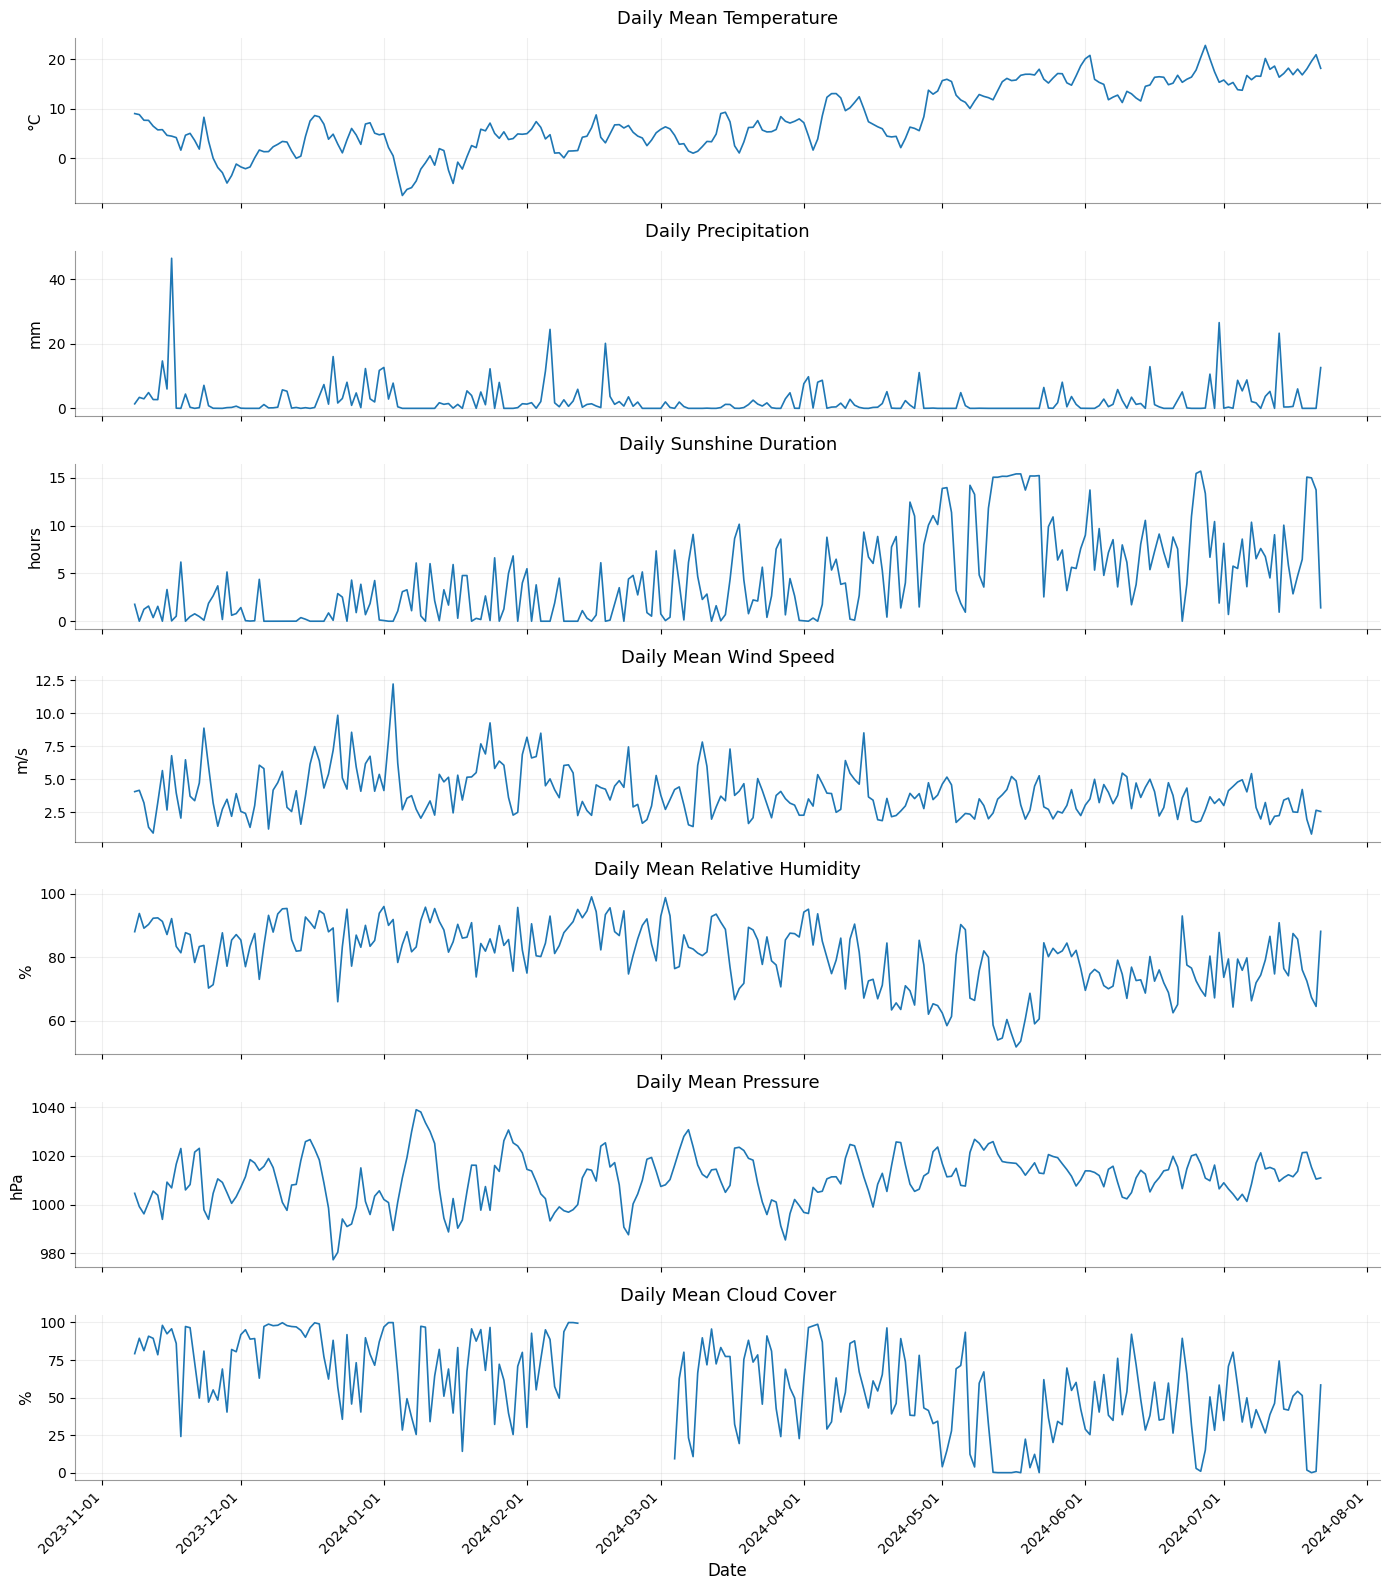

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

parameters = [
    ("mean_temp", "Daily Mean Temperature", "°C"),
    ("acc_precip", "Daily Precipitation", "mm"),
    ("bright_sunshine", "Daily Sunshine Duration", "hours"),
    ("mean_wind_speed", "Daily Mean Wind Speed", "m/s"),
    ("mean_relative_hum", "Daily Mean Relative Humidity", "%"),
    ("mean_pressure", "Daily Mean Pressure", "hPa"),
    ("mean_cloud_cover", "Daily Mean Cloud Cover", "%")
]

fig, axes = plt.subplots(len(parameters), 1, figsize=(14, 16), sharex=True)

for ax, (col, title, ylabel) in zip(axes, parameters):
    
    # daily average
    df_daily = df_weather.groupby("date")[col].mean()

    # plot with nice style
    ax.plot(
        df_daily.index, 
        df_daily.values,
        linewidth=1.2,
    )
    
    # titles and labels
    ax.set_title(title, fontsize=13, pad=10)
    ax.set_ylabel(ylabel, fontsize=11)
    
    # light grid
    ax.grid(True, alpha=0.2)
    
    # remove top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # soften left spine
    ax.spines["left"].set_alpha(0.4)
    ax.spines["bottom"].set_alpha(0.4)

# Format shared X axis
axes[-1].set_xlabel("Date", fontsize=12)

# Rotate dates so they don't overlap
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
axes[-1].xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()



In [5]:
import geopandas as gpd

# Load hex grid
gdf_grid = gpd.read_file("/home/s232713/data/grid_data/cph_hexgrid.geojson")   

# Load boundary of the study area
gdf_boundary = gpd.read_file("/home/s232713/data/grid_data/copenhagen_union_boundary.geojson")

# Ensure consistent CRS
gdf_grid = gdf_grid.to_crs(gdf_boundary.crs)


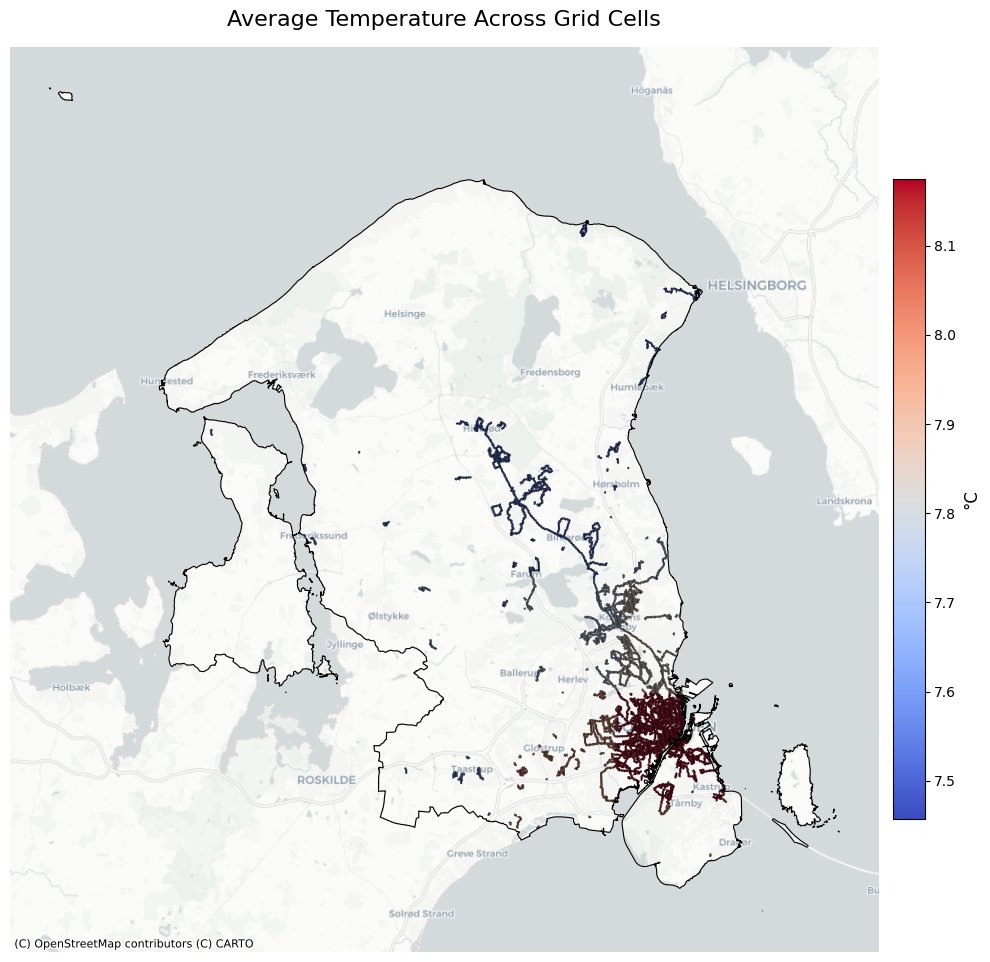

In [ ]:
df_map = df_weather.groupby("GRID_ID").agg(
    mean_temp=("mean_temp", "mean")
).reset_index()

gdf_map = gdf_grid.merge(df_map, on="GRID_ID", how="left")

gdf_map_clip = gpd.clip(gdf_map, gdf_boundary)

import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

# Reproject geometries to Web Mercator
gdf_map_clip_3857 = gdf_map_clip.to_crs(epsg=3857)
gdf_boundary_3857 = gdf_boundary.to_crs(epsg=3857)


fig, ax = plt.subplots(figsize=(10, 10))

# Remove axis noise
ax.set_aspect('equal')
ax.axis("off")

# Colormap (good for temperature)
cmap = plt.cm.coolwarm

# Normalization
norm = mpl.colors.Normalize(
    vmin=gdf_map_clip_3857["mean_temp"].min(),
    vmax=gdf_map_clip_3857["mean_temp"].max()
)

# Plot clipped grid
gdf_map_clip_3857.plot(
    column="mean_temp",
    cmap=cmap,
    linewidth=0.25,
    edgecolor="none",
    norm=norm,
    ax=ax
)

# Add boundary outline on top
gdf_boundary_3857.boundary.plot(
    ax=ax,
    facecolor="none",
    color="black",
    linewidth=0.8
)

# Title
plt.title(
    "Average Temperature Across Grid Cells",
    fontsize=16,
    pad=15
)

# Colorbar professional
cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    fraction=0.035,
    pad=0.015
)
cbar.set_label("°C", fontsize=12)
cbar.ax.tick_params(labelsize=10)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron) # basemap of cph 

plt.tight_layout()
plt.show()


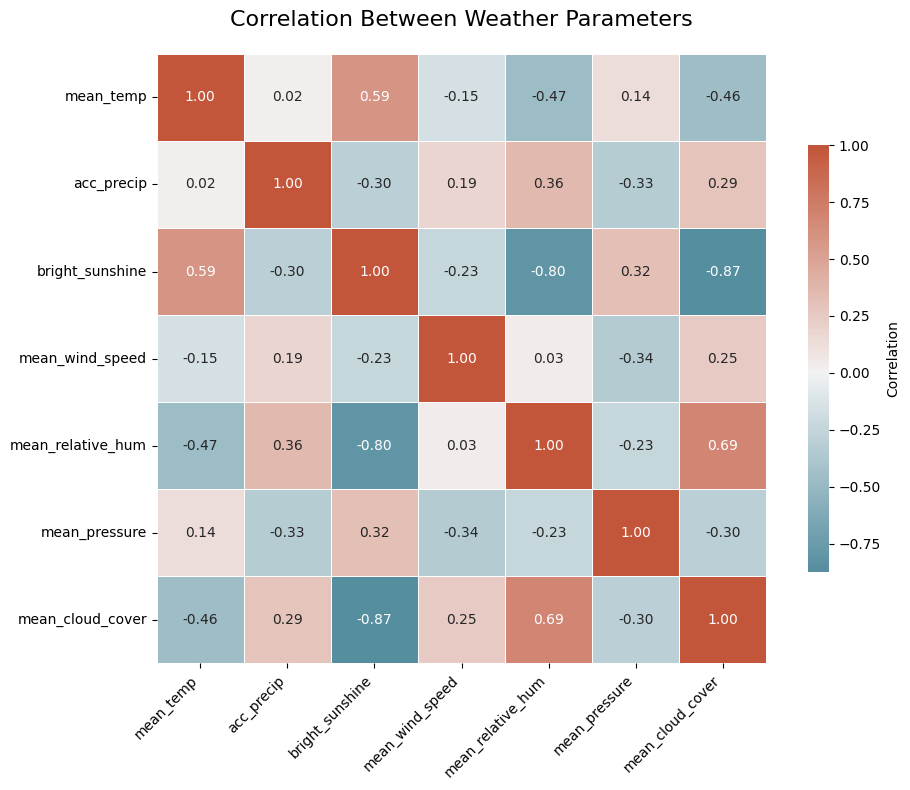

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

corr_df = df_weather[
    [
        "mean_temp",
        "acc_precip",
        "bright_sunshine",
        "mean_wind_speed",
        "mean_relative_hum",
        "mean_pressure",
        "mean_cloud_cover"
    ]
].dropna()

corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))

# Use a clean diverging palette
cmap = sns.diverging_palette(220, 20, as_cmap=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    center=0,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"shrink": 0.7, "label": "Correlation"},
    square=True
)

plt.title("Correlation Between Weather Parameters", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()
